# LGBM

Number of classes: 2
Total parameter combinations: 16

Combination 1/16 at 10:44:57
Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 20, 'n_estimators': 100, 'num_class': 2, 'num_leaves': 31}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12502
[LightGBM] [Info] Number of data points in the train set: 71722, number of used features: 50
[LightGBM] [Info] Start training from score -0.102774
[LightGBM] [Info] Start training from score -2.326173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

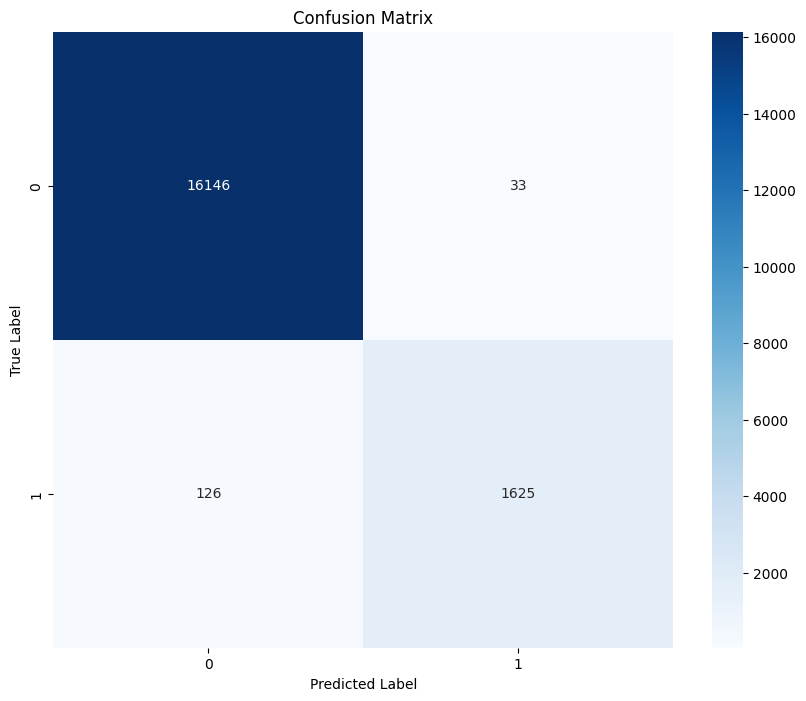

In [19]:
import cudf
import cuml
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid
import numpy as np
import time
import joblib
import pickle

# Convert pandas DataFrame to cuDF
df_gpu = cudf.DataFrame(df)
X = df_gpu.drop('label', axis=1)
y = df_gpu['label']

# Convert data to float32 for better performance
X = X.astype('float32')
y = y.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data using GPU
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to CPU arrays for LightGBM
X_train_cpu = X_train_scaled.values.get()
X_test_cpu = X_test_scaled.values.get()
y_train_cpu = y_train.values.get()
y_test_cpu = y_test.values.get()

# Get number of unique classes
num_classes = len(np.unique(y_train_cpu))
print(f"Number of classes: {num_classes}")

# Define optimized parameter grid
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_samples': [20],
    'num_class': [num_classes]
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')

    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")

    model = lgb.LGBMClassifier(
        objective='multiclass',
        random_state=42,
        **params
    )

    model.fit(X_train_cpu, y_train_cpu)
    train_score = model.score(X_train_cpu, y_train_cpu)
    test_score = model.score(X_test_cpu, y_test_cpu)

    iteration_time = time.time() - iteration_start

    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Training Score: {best_model.score(X_train_cpu, y_train_cpu):.4f}")
print(f"Best Test Score: {best_score:.4f}")

# Save the best model and scaler
model_data = {
    'model': best_model,
    'scaler': scaler,
    'best_params': best_params,
    'best_score': best_score
}
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create simplified fine-tuning grid
fine_tune_grid = {
    'num_leaves': [best_params['num_leaves'] - 10, best_params['num_leaves'], best_params['num_leaves'] + 10],
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'learning_rate': [best_params['learning_rate'] * 0.5, best_params['learning_rate'], best_params['learning_rate'] * 1.5],
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'min_child_samples': [best_params['min_child_samples']],
    'num_class': [num_classes]
}

# Fine-tuning search
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")

    model = lgb.LGBMClassifier(
        objective='multiclass',
        random_state=42,
        **params
    )

    model.fit(X_train_cpu, y_train_cpu)
    test_score = model.score(X_test_cpu, y_test_cpu)

    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model and scaler
final_model_data = {
    'model': best_model,
    'scaler': scaler,
    'best_params': best_params,
    'best_score': best_score
}
with open('lgbm_model_final.pkl', 'wb') as f:
    pickle.dump(final_model_data, f)

# Get predictions and evaluate
y_pred = best_model.predict(X_test_cpu)

# Print evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate and print accuracy
accuracy = accuracy_score(y_test_cpu, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

# Create and plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_cpu, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Function to load the model and make predictions
def load_and_predict(model_path, X_new):
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)

    # Scale the input data
    X_scaled = model_data['scaler'].transform(X_new)

    # Make predictions
    predictions = model_data['model'].predict(X_scaled.values.get())

    return predictions

# Example of how to use the saved model
# predictions = load_and_predict('lgbm_model_final.pkl', X_new)

In [20]:
# Create a dictionary with both model and scaler
model_data = {
     'model': best_model,
     'scaler': scaler
}

# Save using joblib
joblib.dump(model_data, 'LGBM_CPU.pkl')

['LGBM_CPU.pkl']